# Extract pitch values for a given audio stream and return it's mean for respective speakers

This script can be used in speaker identification / speaker verification where it is necessary to distinguish different speakers depending on their audio features ('pitch' in specific). 

In [71]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [72]:
data_dir = '/home/user/wav_files_dir' # directory of all your .wav files

In [73]:
def extract_max(pitches,magnitudes, shape):
    new_pitches = []
    new_magnitudes = []
    for i in range(0, shape[1]):
        new_pitches.append(np.max(pitches[:,i]))
        new_magnitudes.append(np.max(magnitudes[:,i]))
    return (new_pitches,new_magnitudes)

def smooth(x,window_len=5,window='hamming'):
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman', 'rectangular']:
        raise ValueError("Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman', 'rectangular'")
    s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='same')
    return y[window_len:-window_len+1]

def set_variables(sample_f,duration,window_time,fmin,fmax,overlap):
    total_samples = sample_f * duration
    #There are sample_f/1000 samples / ms
    #windowsize = number of samples in one window
    window_size = sample_f/1000 * window_time
    hop_length = total_samples / window_size
    #Calculate number of windows needed
    needed_nb_windows = total_samples / (window_size - overlap)
    n_fft = needed_nb_windows * 2.0
    return total_samples, window_size, needed_nb_windows, n_fft, hop_length

def plot(vector, name, xlabel=None, ylabel=None):
    plt.figure()
    plt.plot(vector)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot()
    plt.savefig(name)

#Set all wanted variables

#we want a sample frequency of 16 000
sample_f = 48000
#The duration of the voice sample
duration = 2
#We want a windowsize of 30 ms
window_time = 60
fmin = 80
fmax = 250
#We want an overlap of 10 ms
overlap = 20
total_samples, window_size, needed_nb_windows, n_fft, hop_length = set_variables(sample_f, duration, window_time, fmin, fmax, overlap)

### A sample plot for the sentence 'noise cancellation off'

172

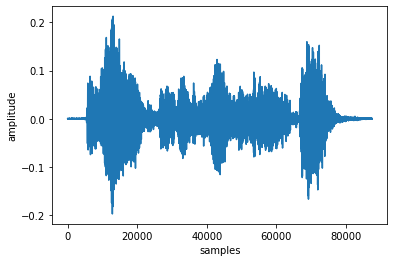

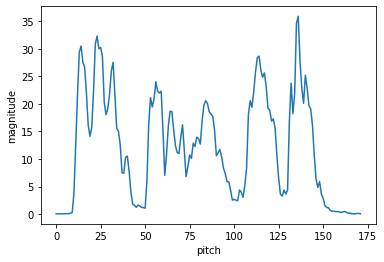

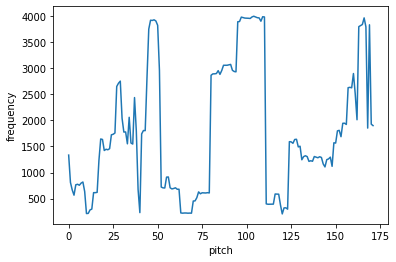

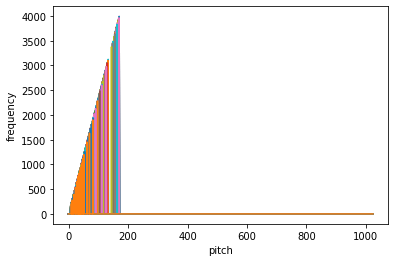

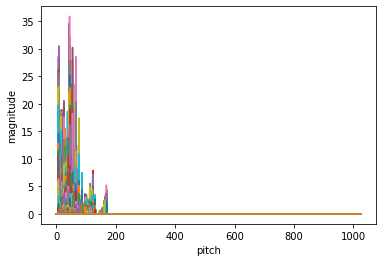

In [152]:
y, sr = librosa.load(data_dir + 'sample.wav', sr=sample_f)
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

shape = np.shape(pitches)
#nb_samples = total_samples / hop_length
nb_samples = shape[0]
#nb_windows = n_fft / 2
nb_windows = shape[1]
pitches1,magnitudes1 = extract_max(pitches, magnitudes, shape)

pitches2 = smooth(pitches1,window_len=10)
plot(y, 'audio', xlabel='samples', ylabel='amplitude')
plot(magnitudes1, 'magnitudes', xlabel='pitch', ylabel='magnitude')
plot(pitches1, 'pitches1', xlabel='pitch', ylabel='frequency')

plot(pitches, 'pitches1', xlabel='pitch', ylabel='frequency')
plot(magnitudes, 'magnitudes', xlabel='pitch', ylabel='magnitude')

len(pitches1)

### Choose a threshold such that only the values above this magnitude represent actual voice

In [139]:
mag_threshold = (np.array(magnitudes1).mean())*1.5
mag_threshold

18.494065761566162

### Count all the instances that appear above this threshold and find its mean

In [143]:
pitch_total = 0
pitch_count = 0
for magnitude, pitch in zip(magnitudes1, pitches1):
    if magnitude >= mag_threshold:
        pitch_total += pitch
        pitch_count+= 1

pitch_mean = pitch_total / pitch_count
pitch_mean = round(pitch_mean, 2)
print(pitch_mean)
print(pitch_total)
print(pitch_count)

1285.17
69398.91302490234
54


## This mean value represents the unique pitch for a respective speaker. This could serve as a fingerprint for speaker recognition